# From biological to Artificial neuron

## The Perceptron

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target == 0  # Iris Setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [2]:
per_clf.predict([[2, 0.5], [3, 1]])

array([ True, False])

The Perceptron is equivalent to an SGDClassifier, implemented as following code cell.

In [3]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42
)
sgd_clf.fit(X, y)
assert (sgd_clf.intercept_ == per_clf.intercept_).all()
assert (sgd_clf.coef_ == per_clf.coef_).all()

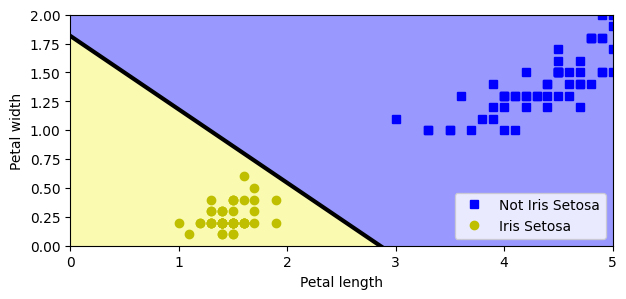

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]

axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.legend(loc="lower right")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([0, 5, 0, 2])
plt.show()

**Activation function**

Here we plot some popular activation functions and their derivatives.

In [5]:
from scipy.special import expit as sigmoid


def relu(z):
    return np.maximum(z, 0)


def derivate(f, z, epsilon=1e-6):
    return (f(z + epsilon) - f(z)) / epsilon


max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

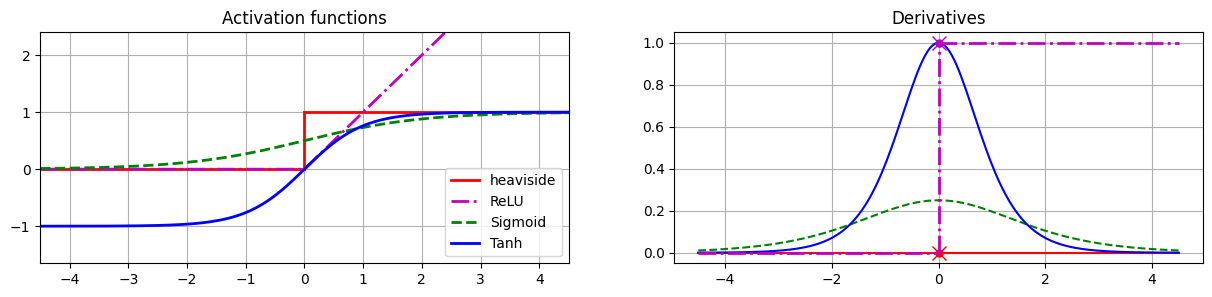

In [6]:
plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot([0, 0], [0, 1], "r-", linewidth=2)
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.grid()
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.title("Activation functions")
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(z, derivate(sigmoid, z), "g--")
plt.plot(z, derivate(np.sign, z), "r-")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivate(np.tanh, z), "b-")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid()
plt.title("Derivatives")

plt.show()

## Regression MLPs

We can train MLP using MLPRegressor in scikit-learn. <br>

Its parameters is very similar to Linear Regression, so here I will just explain the unique parameters of MLPRegressor:
- hidden_layer_sizes: A list contains the number of neuron in each hidden layer.
- activation: Activation functions used in the neural network
- solver: the weight optimization algorithm, default is Adam
- alpha: the hyperparameter for regularization, default is a bit of regularization.

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

mlp_reg = MLPRegressor([50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_predict, squared=False)

In [8]:
rmse

0.5053326657968512

The error is about 0.505, comparable with a Random Forest, which is not bad for our first try!

## Classification MLPs

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000, random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras

## Building an Image Classifier Using the Sequential API

### Using Keras to load the dataset

- We start by loading the Fashion MNIST dataset. Keras has a number of function to load popular datasets in `tf.keras.datasets`. 
- The dataset is already shuffled and split into a training set (60,000 images) and a test set (10,000 images). We'll hold out the last 5,000 images from the training set for validation.

In [10]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

2024-02-19 15:17:45.740812: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 15:17:45.771922: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 15:17:45.889473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 15:17:45.889539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 15:17:45.905538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The training set contains 55,000 greyscale images, each 28x28 pixels.

In [11]:
X_train.shape

(55000, 28, 28)

Each pixel intensities is represented as a byte (0 to 255).

In [12]:
X_train.dtype

dtype('uint8')

We scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing them by 255. 

In [13]:
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

We can plot an image using Matplotlib's `imshow()` function, with a `'binary'` color map.

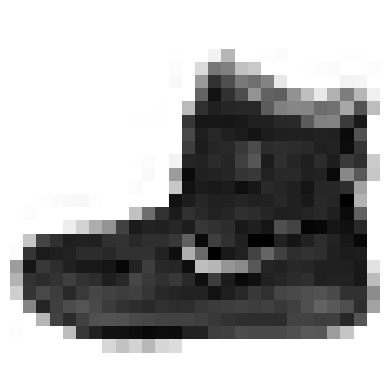

In [14]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9.

In [15]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [16]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

So the first image in the training set is an ankle boot.

In [17]:
class_names[y_train[0]]

'Ankle boot'

Here we plot the first 40 images in the training set. 

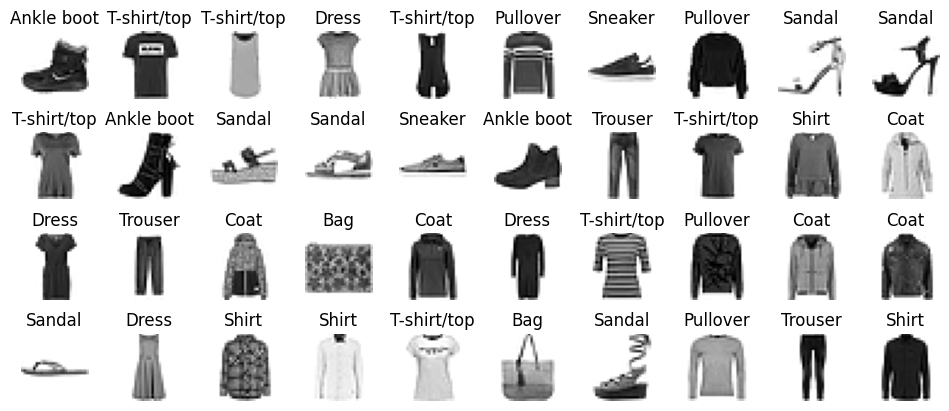

In [18]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary")
        plt.axis("off")
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

### Creating the model using the sequential API

In [19]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

We go through this code line by line in note.md.

It's often preferable to pass a list of layers when creating the `Sequential` model. You can slo drop the `Input` layer and specify the `input_shape` in the first layer.

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
from keras.src.engine.sequential import Sequential

model: Sequential = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


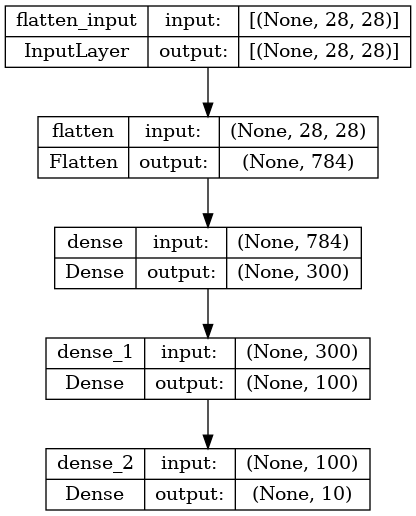

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

We can get a list of a model's layers by using the `layers` attribute, or use the `get_layer()` method to access the layer by name.

In [23]:
model.layers

In [24]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [25]:
model.get_layer("dense") is hidden1

True

All the parameters of a layer cna be accessed using its `get_weights()` and `set_weights()` methods. For a `Dense` layer, this includes both the connection weights and the bias terms.

In [26]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02702137, -0.05388264, -0.0202316 , ...,  0.06573239,
        -0.03080354,  0.01759098],
       [ 0.05770317, -0.06066151,  0.04131815, ...,  0.04736374,
        -0.05062135,  0.0347892 ],
       [-0.01130265, -0.03318485,  0.02969872, ...,  0.05943632,
        -0.04709913,  0.00959873],
       ...,
       [-0.02118387,  0.06830178, -0.02266655, ...,  0.07338692,
        -0.05474193, -0.04794909],
       [-0.00362392,  0.04241195, -0.05421828, ..., -0.02402864,
         0.01908143, -0.00877444],
       [ 0.05750586, -0.02515183,  0.02238643, ..., -0.04464212,
        -0.06131013,  0.007571  ]], dtype=float32)

In [27]:
weights.shape

(784, 300)

In [28]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [29]:
biases.shape

(300,)

### Compiling the model

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)

This is equivalent to:

In [35]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy],
)

This code shows how to convert class ids to one-hot vectors.

In [37]:
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: It's important to set `num_classes` when the number of classes is greater than the maximum class ids in the sample.

This code shows how to convert one-hot vectors to class ids

In [38]:
np.argmax(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ],
    axis=1,
)

array([0, 5, 1, 0])